## Sztuczne sieci neuronowe - laboratorium 4

### Sieci neuronowe

Podczas poprzednich dwóch ćwiczeń:
- poszukiwaliśmy parametrów **modelu liniowego**, aby dopasować go do danych
- zdefiniowaliśmy funkcję straty dla regresji - błąd średniokwardratowy (MSE)
- użyliśmy algorytmu najszybszego spadku, aby znaleźć optymalne parametry modelu
- najpierw robiliśmy wsystkie te kroki "ręcznie", potem poznaliśmy możliwości PyTorch autograd i torch.optim.

Dziś zastąpimy model liniowy prostą siecią neuronową.

**Sieć neuronowa** to przykład modelu bardziej złożonego niż model liniowy. 

Algorytmy uczenia sieci neuronowych nie różnią się jednak szczególnie od poznanych już na zajęciach - powszechnie stosuje się algorytm najszybszego spadku lub jeden z jego bardziej zaawansowanych wariantów (SGD+momentum, Adagrad, RMSProp, Adam, ...).

Podstawowym składnikiem sieci neuronowej jest **neuron**.
Równanie neuronu można zapisać jako `o = f(w * x + b)`, gdzie `x` to dane wejściowe, `w` i `b` to parametry (wagi), a `f` to funkcja aktywacji. Neurony składają się na **warstwy** tworzące sieć neuronową.

Najpierw wrócimy jednak do modelu liniowego.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
data_unknown = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
data_celsius = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]

t_u = torch.tensor(data_unknown)
t_c = torch.tensor(data_celsius)

t_u_mean = t_u.mean()
t_u_std = t_u.std()

t_un = (t_u - t_u_mean) / t_u_std

### Zbiór uczący i walidacyjny

Zadaniem modelu nie jest zapamiętanie danych uczących, ale nauczenie się wzorców, które "poradzą sobie" także z przykładami niewidzianymi podczas treningu. Zbiór danych - w przypadku walidacji prostej - należy podzielić na dwa podzbiory, a następnie uczyć model na jednym z nich (zbiór uczący) i sprawdzać jego działanie na innym (zbiór walidacyjny/testowy).

    #### Ćwiczenie
    Podziel zbiór danych na zbiór uczący i walidacyjny, losując 20% elementów (na podstawie ich indeksów) tensora `t_un` do zbioru walidacyjnego. Wykorzystaj funkcję `torch.randperm`.

    https://pytorch.org/docs/stable/generated/torch.randperm.html

    Przypisz podzielone tensory `t_u`, `t_un` i `t_c` do zmiennych `train_t_u`, `val_t_u` itd.

In [25]:
train_size = int(0.8 * len(t_u))
rand_idx = torch.randperm(len(t_u))

train_indices = rand_idx[:train_size]
print(train_indices)

val_indices = rand_idx[train_size:]
print(val_indices)

train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = t_un[train_indices]
val_t_un = t_un[val_indices]

print(t_un)
print(train_t_un)
print(val_t_un)

tensor([ 1,  6,  7,  0,  2,  4, 10,  8])
tensor([3, 5, 9])
tensor([-0.9565,  0.2436,  0.3802,  1.7883,  0.2673, -0.1723, -1.0635, -1.7823,
        -0.2020,  0.5109,  0.9862])
tensor([ 0.2436, -1.0635, -1.7823, -0.9565,  0.3802,  0.2673,  0.9862, -0.2020])
tensor([ 1.7883, -0.1723,  0.5109])


#### Pętla treningowa - walidacja modelu

W procesie poszukiwania parametrów modelu dokonujemy aktualizacji parametrów modelu na podstawie funkcji straty dla zbioru uczącego. Należy także monitorować funkcję straty na zbiorze walidacyjnym, na przykład w celu uniknięcia przeuczenia modelu.

Jako że na zbiorze walidacyjnym nie musimy wykonywać kroku "wstecz", nie wywołujemy `val_loss.backward()`. W związku z tym nie ma potrzeby budowania grafu - w celu przyspieszenia obliczeń fragmenty kodu związane z walidacją możemy zamknąć w bloku `with torch.no_grad()`.

In [12]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

### torch.nn

https://pytorch.org/docs/stable/nn.html

Moduł PyTorcha `torch.nn` zawiera implementacje różnych elementów (warstw) tworzących sieci neuronowe. Elementy te w PyTorchu nazywa się modułami ("modules") - realizowane są jako klasy dziedziczące po klasie bazowej `nn.Module`.

Najprostszym przykładem modułu jest warstwa liniowa (gęsta) `nn.Linear`, która jest równoważna modelowi liniowemu (funkcja `model`) z przykładu z termometrami z poprzednich ćwiczeń.

Konstruktor `nn.Linear` przyjmuje 3 argumenty - rozmiar wejścia (liczbę cech - oraz przypisanych im wag `w`), rozmiar wyjścia oraz argument True/False, czy uwzględniać wyraz wolny (`b`) - domyślnie True.

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

### Ćwiczenie

Stwórz model liniowy używając modułu `nn.Linear`. Poeksperymentuj z różnymi wartościami argumentów konstruktora: `in_features`, `out_features` oraz `bias`. Zobacz, jak zmienia się zawartość atrybutów `linear_model.weight` i `linear_model.bias`. Sprawdź zawartość `list(model.parameters())`.

In [19]:
in_features = 3
out_features = 1
bias = True

linear_model = nn.Linear(in_features, out_features, bias)

print("Wagi modelu:")
print(linear_model.weight)
print("\nBias modelu:")
print(linear_model.bias)

print("\nParametry modelu:")
for param in linear_model.parameters():
    print(param)

Wagi modelu:
Parameter containing:
tensor([[ 0.0370, -0.3756, -0.2874]], requires_grad=True)

Bias modelu:
Parameter containing:
tensor([-0.4069], requires_grad=True)

Parametry modelu:
Parameter containing:
tensor([[ 0.0370, -0.3756, -0.2874]], requires_grad=True)
Parameter containing:
tensor([-0.4069], requires_grad=True)


#### Ćwiczenie
W przypadku "wrzucania" do modelu wielu (N) obserwacji jednocześnie (tzw. batch danych) należy zadbać o odpowiednie wymiary tensora (tu: tensor kolumnowy N x 1). W tym celu należy użyć funkcji `unsqueeze`.

https://pytorch.org/docs/stable/generated/torch.unsqueeze.html

Sprawdź, jaką wartość ma atrybut `.shape` tensora `t_un` przed i po użyciu funkcji `unsqueeze`.

Następnie przepuść tensor zawierający znormalizowane dane wejściowe przez model (dobierz odpowiednie rozmiary wejścia i wyjścia `nn.Linear`). W tym celu można po prostu wywołać `model(dane_wejsciowe)` - jest to wywołanie metody `__call__` klasy `nn.Linear`.

In [21]:
print("Wymiary tensora przed unsqueeze:", t_un.shape)

t_un_batched = t_un.unsqueeze(1)

print("Wymiary tensora po unsqueeze:", t_un_batched.shape)

in_features = 1  
out_features = 1  
bias = True

model = nn.Linear(in_features, out_features, bias)

output = model(t_un_batched)

print("Wyjście modelu:", output)

Wymiary tensora przed unsqueeze: torch.Size([11])
Wymiary tensora po unsqueeze: torch.Size([11, 1])
Wyjście modelu: tensor([[-1.4588],
        [-0.3249],
        [-0.1958],
        [ 1.1347],
        [-0.3024],
        [-0.7178],
        [-1.5599],
        [-2.2391],
        [-0.7459],
        [-0.0723],
        [ 0.3768]], grad_fn=<AddmmBackward0>)


#### Ćwiczenie

Uzupełnij poniższe komórki:
- uzupełnij funkcję `training_loop_torch_nn`
- zainicjalizuj model liniowy i optymalizator SGD dla learning rate 0.01
- następnie wywołaj ją dla 1000 iteracji (epok)

`torch.nn` zawiera także implementacje różnych funkcji straty. Przy wywołaniu pętli treningowej podaj funkcję straty `nn.MSELoss()`.

Po wywołaniu pętli uczącej zajrzyj w parametry modelu - atrybuty `.weight` i `.bias`



In [31]:
# ZASTĄP SŁOWA None KODEM / DOPISZ LINIE KODU WE WSKAZANYCH MIEJSCACH

def training_loop_torch_nn(n_iters, optimizer, model, loss_fn, train_t_u, val_t_u, train_t_c, val_t_c, verbose=True):
    for iteration in range(n_iters+1):    
        train_t_p = model(train_t_u)
        loss_train = loss_fn(train_t_p,train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u)
            loss_val = loss_fn(val_t_p,val_t_c)
        
        # dopisz tu kolejno:
        # - zerowanie gradientów
        # - obliczenie gradientów (która funkcja to robi?)
        # - krok aktualizacji parametrów
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if verbose:
            print('Epoch %d, Training loss %f, validation loss: %f' % (iteration, loss_train.item(), loss_val.item()))


In [32]:
# ZASTĄP SŁOWA None KODEM

model = nn.Linear(in_features, out_features, bias)
optimizer = optim.SGD(model.parameters(), lr=0.01)

linear_model = model
optimizer = optimizer

training_loop_torch_nn(
    n_iters = 1000,
    optimizer = optimizer,
    model = linear_model, 
    loss_fn = nn.MSELoss(),
    train_t_u = train_t_un.unsqueeze(1),
    val_t_u = val_t_un.unsqueeze(1),
    train_t_c = train_t_c.unsqueeze(1),
    val_t_c = val_t_c.unsqueeze(1)
)

Epoch 0, Training loss 132.675659, validation loss: 343.850677
Epoch 1, Training loss 129.104721, validation loss: 335.118500
Epoch 2, Training loss 125.638954, validation loss: 326.614532
Epoch 3, Training loss 122.274971, validation loss: 318.332642
Epoch 4, Training loss 119.009506, validation loss: 310.266937
Epoch 5, Training loss 115.839417, validation loss: 302.411530
Epoch 6, Training loss 112.761650, validation loss: 294.760834
Epoch 7, Training loss 109.773293, validation loss: 287.309296
Epoch 8, Training loss 106.871490, validation loss: 280.051636
Epoch 9, Training loss 104.053551, validation loss: 272.982697
Epoch 10, Training loss 101.316818, validation loss: 266.097382
Epoch 11, Training loss 98.658745, validation loss: 259.390839
Epoch 12, Training loss 96.076881, validation loss: 252.858261
Epoch 13, Training loss 93.568848, validation loss: 246.495041
Epoch 14, Training loss 91.132370, validation loss: 240.296646
Epoch 15, Training loss 88.765251, validation loss: 23

In [33]:
print("Wagi modelu:")
print(linear_model.weight)
print("\nBias modelu:")
print(linear_model.bias)

print("\nParametry modelu:")
for param in linear_model.parameters():
    print(param)

Wagi modelu:
Parameter containing:
tensor([[8.8622]], requires_grad=True)

Bias modelu:
Parameter containing:
tensor([10.6686], requires_grad=True)

Parametry modelu:
Parameter containing:
tensor([[8.8622]], requires_grad=True)
Parameter containing:
tensor([10.6686], requires_grad=True)


### Sieć neuronowa

Zastąpimy teraz model liniowy prostą siecią neuronową. Wszystko poza modelem pozostanie bez zmian.

Będzie to najprostsza możliwa sieć neuronowa, złożona kolejno z:
- warstwy liniowej (`nn.Linear`)
- funkcji aktywacji (`nn.Tanh`, `nn.Sigmoid` lub `nn.ReLU`)
- kolejnej warstwy liniowej

Pierwsza warstwa liniowa razem z funkcją aktywacji nazywana jest warstwą ukrytą ("hidden layer").

Sieć neuronową można stworzyć z wykorzystaniem klasy `nn.Sequential`:
https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

Argumentami konstruktora są kolejne warstwy sieci.

#### Ćwiczenie
Stwórz sieć neuronową zgodną z powyższym opisem. Liczba wyjść z pierwszej warstwy liniowej musi być równa liczbie wejść do drugiej warstwy liniowej. Przypisz model do zmiennej `seq_model` i sprawdź jej zawartość.

Dobór architektury (liczby warstw, liczby neuronów w warstwach, funkcji aktywacji...) jest przedmiotem eksperymentów.
Początkowo przyjmijmy funkcję aktywacji: tangens hiperboliczny oraz rozmiar wyjścia z pierwszej / wejścia do drugiej warstwy równy 13.

In [34]:
class SimpleSequentialNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleSequentialNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(), 
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.layers(x)

input_size = 1  
hidden_size = 13  
output_size = 1  

seq_model = SimpleSequentialNN(input_size, hidden_size, output_size)

print(seq_model)

SimpleSequentialNN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=13, bias=True)
    (1): Tanh()
    (2): Linear(in_features=13, out_features=1, bias=True)
  )
)


####  Ćwiczenie
Stwórz optymalizator SGD i przypisz mu parametry modelu `seq_model`.
Następnie uruchom `training_loop_torch_nn` - co musisz zmienić względem poprzedniego ćwiczenia z wywołaniem tej funkcji?

In [35]:
# Tworzenie optymalizatora SGD
optimizer = optim.SGD(seq_model.parameters(), lr=0.01)

# Wywołanie funkcji training_loop_torch_nn
training_loop_torch_nn(
    n_iters=1000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    train_t_u=train_t_un.unsqueeze(1),
    val_t_u=val_t_un.unsqueeze(1),
    train_t_c=train_t_c.unsqueeze(1),
    val_t_c=val_t_c.unsqueeze(1)
)

Epoch 0, Training loss 126.856438, validation loss: 327.557098
Epoch 1, Training loss 115.006737, validation loss: 306.085175
Epoch 2, Training loss 104.576134, validation loss: 286.657654
Epoch 3, Training loss 95.078133, validation loss: 268.465057
Epoch 4, Training loss 86.253639, validation loss: 251.074997
Epoch 5, Training loss 77.984863, validation loss: 234.301987
Epoch 6, Training loss 70.236481, validation loss: 218.119308
Epoch 7, Training loss 63.014320, validation loss: 202.592239
Epoch 8, Training loss 56.337330, validation loss: 187.826340
Epoch 9, Training loss 50.220898, validation loss: 173.929077
Epoch 10, Training loss 44.669102, validation loss: 160.986008
Epoch 11, Training loss 39.673218, validation loss: 149.049118
Epoch 12, Training loss 35.213394, validation loss: 138.135193
Epoch 13, Training loss 31.261524, validation loss: 128.229935
Epoch 14, Training loss 27.784004, validation loss: 119.294830
Epoch 15, Training loss 24.743944, validation loss: 111.274559

In [37]:

print("\nParametry modelu:")
for param in seq_model.parameters():
    print(param)


Parametry modelu:
Parameter containing:
tensor([[-0.8254],
        [ 1.3307],
        [-0.0621],
        [ 2.1691],
        [-2.0776],
        [-0.7386],
        [-0.1740],
        [-0.7848],
        [ 0.5207],
        [ 0.2076],
        [ 1.9114],
        [-0.5050],
        [-0.9097]], requires_grad=True)
Parameter containing:
tensor([ 0.4259, -0.5705,  1.5669, -0.6009,  0.6148, -1.3641, -0.5022, -1.3732,
         0.9476, -1.4396, -0.6238, -0.8841, -1.5666], requires_grad=True)
Parameter containing:
tensor([[-0.5206,  1.0378,  1.3338,  2.4568, -1.9079, -1.7107, -0.4138, -1.8297,
          2.6019, -0.9335,  2.4221, -1.3192, -2.5353]], requires_grad=True)
Parameter containing:
tensor([2.5414], requires_grad=True)


#### Ćwiczenie

Uruchom poniższą komórkę, aby zwizualizować dopasowanie sieci neuronowej do danych. Co możesz powiedzieć o tym dopasowaniu?

Następnie poeksperymentuj z różnymi funkcjami aktywacji i liczbą neuronów w warstwach liniowych. 

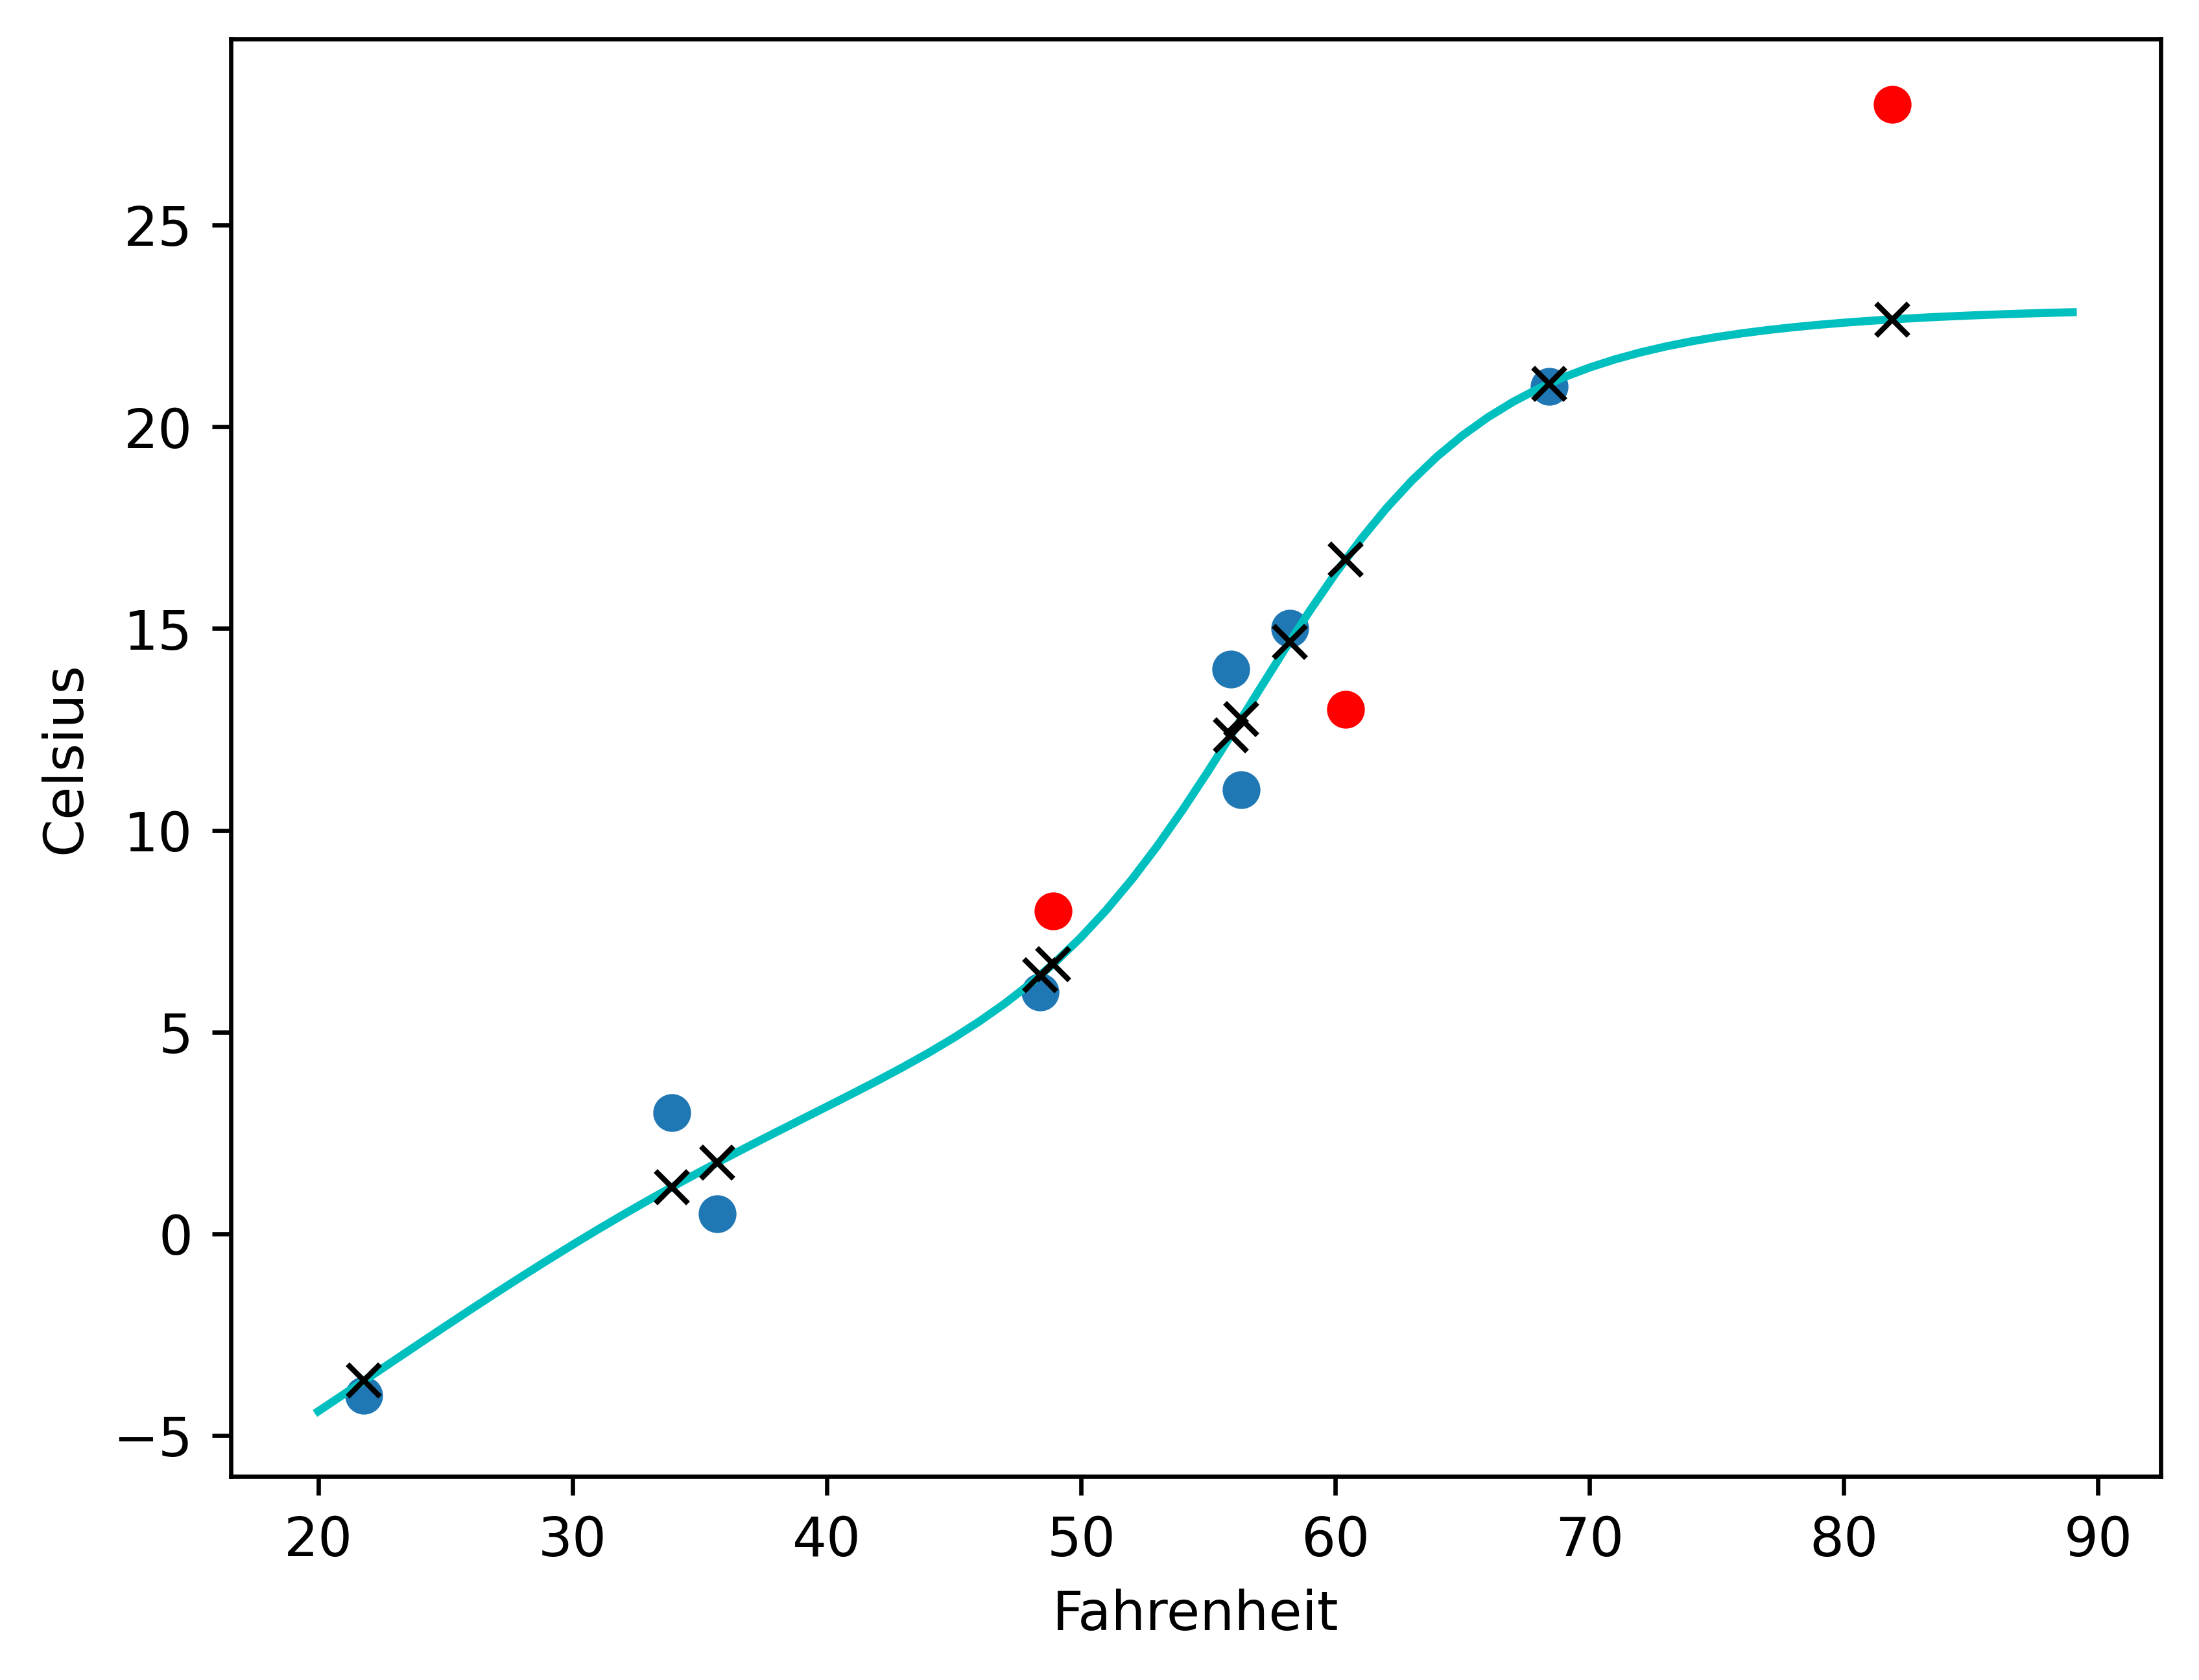

In [38]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(train_t_u.numpy(), train_t_c.numpy(), 'o')
plt.plot(val_t_u.numpy(), val_t_c.numpy(), 'ro')
plt.plot(t_range.numpy(), seq_model((t_range - t_u_mean)/t_u_std).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(t_un.unsqueeze(1)).detach().numpy(), 'kx')